# Import

In [2]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn import metrics
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
from xgboost import plot_importance
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report

# Create Test and Train Data

In [3]:
url = 'https://raw.githubusercontent.com/elymsyr/iris-recognition/main/Database/kp_classify_blur.csv'

df = pd.read_csv(url)

# df = pd.read_csv('kp_classify_blur.csv')
df.head()

,match,image_tag,pos,point_x,point_y,size,angle,response,octave,blur
0,0,S6722S03,right-side,45,111,31.000000,28.460091,0.000393,0,11.132859
1,0,S6735S09,right-side,53,118,44.640003,8.228042,0.000368,2,19.968516
2,0,S6722S03,left-side,46,131,44.640003,169.835007,0.000731,2,11.132859
3,0,S6735S09,left-side,42,75,37.200001,2.890326,0.000027,1,19.968516
4,0,S6722S03,left-side,32,74,31.000000,215.737335,0.000347,0,11.132859


In [4]:
# dividing the datasets into two parts i.e. training datasets and test datasets
mapping = {'right-side': 0, 'left-side': 1, 'bottom': 2, 'complete': 3}
df['pos'] = df['pos'].map(mapping)

# df = df.sample(n=400000, random_state=42).reset_index(drop=True)
df = df.drop(['octave'], axis=1)

In [5]:
# Separate majority and minority classes
df_class_0 = df[df['match'] == 0]
df_class_1 = df[df['match'] == 1]

# Determine the number of samples to keep
n_samples = min(len(df_class_0), len(df_class_1))

# Undersample the majority class
df_class_0_balanced = df_class_0.sample(n=n_samples, random_state=42)
df_class_1_balanced = df_class_1.sample(n=n_samples, random_state=42)

# Combine the balanced classes
df_balanced = pd.concat([df_class_0_balanced, df_class_1_balanced])

# Shuffle the data
df = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

In [6]:
print(df['match'].value_counts())

match
0    333688
1    333688
Name: count, dtype: int64


In [7]:
y = df['match']
X = df.drop(labels=['match', 'image_tag'], axis=1)

# print(X)

# print(y[:2])
# print(X[:2])

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15)

 # Functions

In [9]:
def RandomForest(X_train, X_test, y_train, y_test, parameters = {'n_estimators': 100,
                                     'max_depth': None,
                                     'max_features': 'sqrt',
                                     'criterion': 'gini',
                                     'bootstrap': True,
                                     'class_weight' : "balanced",
                                     'max_samples': None
                                     }):
    clf = RandomForestClassifier(n_estimators = 100)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # using metrics module for accuracy calculation
    accuracy = metrics.accuracy_score(y_test, y_pred)
    feature_imp = pd.Series(clf.feature_importances_, index = X.keys()).sort_values(ascending = False)
    return accuracy, feature_imp, clf

In [10]:
def XGBoost(X_train, X_test, y_train, y_test, model_path='xgboost_model.json', threshold: float = 0.5, params: dict = { 'objective': 'binary:logistic', 'eval_metric': 'auc', 'eta': 0.1, 'max_depth': 10, 'min_child_weight': 1, 'subsample': 0.8, 'colsample_bytree': 0.8, 'lambda': 1, 'alpha': 0, 'seed': 4 }):
    # Initialize MinMaxScaler
    scaler = MinMaxScaler(feature_range=(0,1))

    # Fit and transform the training data, transform the test data
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Convert scaled data to DMatrix format (optimized for XGBoost)
    dtrain = xgb.DMatrix(X_train_scaled, label=y_train)
    dtest = xgb.DMatrix(X_test_scaled, label=y_test)

    # Train the model
    bst = xgb.train(params, dtrain, num_boost_round=10000, evals=[(dtest, 'test')], early_stopping_rounds=50, verbose_eval=10)

    # Predict
    y_pred = bst.predict(dtest)
    predictions = [1 if x > threshold else 0 for x in y_pred]

    # Evaluate the model
    accuracy = accuracy_score(y_test, predictions)
    auc = roc_auc_score(y_test, y_pred)

    # Print evaluation metrics
    print(f'Accuracy: {accuracy:.4f}')
    print(f'AUC: {auc:.4f}')

    # Save the model
    bst.save_model(model_path)

    # Return the model and metrics
    return bst, accuracy, auc, y_pred, predictions, dtrain, dtest

# loaded_model = xgb.Booster()
# loaded_model.load_model('xgboost_model.json')

# Train Model

In [11]:
params = {
    'objective': 'binary:logistic',  # Binary classification
    'eval_metric': 'auc',  # Evaluation metric, AUC is a common choice
    'eta': 0.1,  # Learning rate
    'max_depth': 10,  # Maximum depth of a tree
    'min_child_weight': 1,  # Minimum sum of instance weight (hessian) needed in a child
    'subsample': 0.8,  # Subsample ratio of the training instances
    'colsample_bytree': 0.8,  # Subsample ratio of columns when constructing each tree
    'lambda': 1,  # L2 regularization term on weights
    'alpha': 0,  # L1 regularization term on weights
    'seed': 42  # Random seed for reproducibility
}

threshold=0.6

In [12]:
bst, accuracy, auc, y_pred, predictions, dtrain, dtest = XGBoost(X_train, X_test, y_train, y_test, threshold=threshold, params=params)

[0]	test-auc:0.61719
[10]	test-auc:0.64511
[20]	test-auc:0.65632
[30]	test-auc:0.66146
[40]	test-auc:0.66843
[50]	test-auc:0.67425
[60]	test-auc:0.67660
[70]	test-auc:0.67968
[80]	test-auc:0.68138
[90]	test-auc:0.68295
[100]	test-auc:0.68476
[110]	test-auc:0.68612
[120]	test-auc:0.68750
[130]	test-auc:0.68879
[140]	test-auc:0.68990
[150]	test-auc:0.69061
[160]	test-auc:0.69149
[170]	test-auc:0.69262
[180]	test-auc:0.69301
[190]	test-auc:0.69373
[200]	test-auc:0.69433
[210]	test-auc:0.69486
[220]	test-auc:0.69553
[230]	test-auc:0.69618
[240]	test-auc:0.69690
[250]	test-auc:0.69716
[260]	test-auc:0.69764
[270]	test-auc:0.69830
[280]	test-auc:0.69880
[290]	test-auc:0.69922
[300]	test-auc:0.69951
[310]	test-auc:0.69962
[320]	test-auc:0.70013
[330]	test-auc:0.70043
[340]	test-auc:0.70077
[350]	test-auc:0.70110
[360]	test-auc:0.70139
[370]	test-auc:0.70171
[380]	test-auc:0.70199
[390]	test-auc:0.70216
[400]	test-auc:0.70238
[410]	test-auc:0.70270
[420]	test-auc:0.70291
[430]	test-auc:0.70318

0.635969512621495 0.7071642602519491


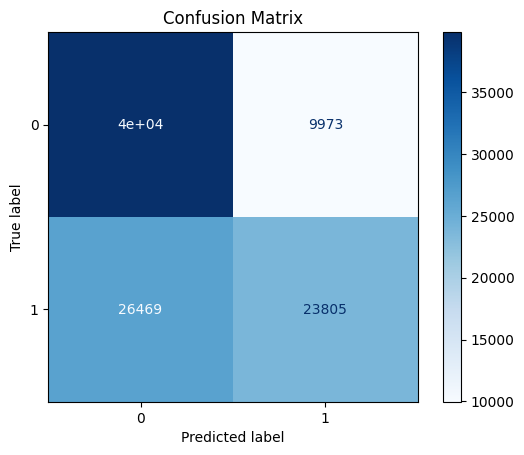

              precision    recall  f1-score   support

           0       0.60      0.80      0.69     49833
           1       0.70      0.47      0.57     50274

    accuracy                           0.64    100107
   macro avg       0.65      0.64      0.63    100107
weighted avg       0.65      0.64      0.63    100107



In [13]:
print(accuracy, auc)
conf_matrix = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
print(classification_report(y_test, predictions))

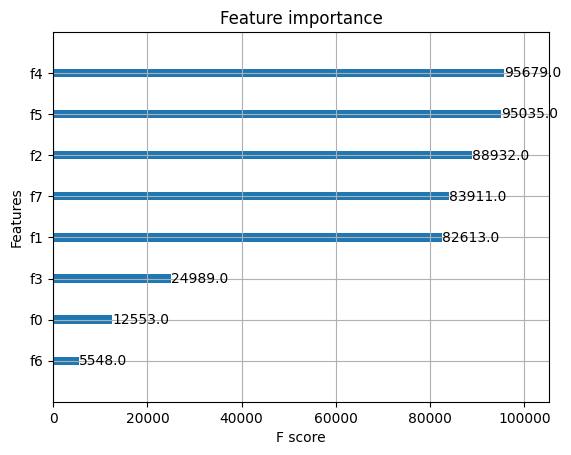

In [14]:
plot_importance(bst)
plt.show()

# Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# Define the model
model = XGBClassifier(eval_metric='auc')

param_grid = {
    'objective': ['binary:logistic'],  # Keeping it for binary classification
    'eval_metric': ['auc'],  # AUC is a common evaluation metric
    'learning_rate': [0.1],  # Learning rate (eta), typically small
    'max_depth': [None, 12],  # Depth of trees; small to moderate values to prevent overfitting
    'min_child_weight': [1, 3],  # Minimum sum of instance weight needed in a child; values to regularize
    # 'subsample': [0.6, 0.8, 1.0],  # Subsample ratio of the training instances; controlling overfitting
    # 'colsample_bytree': [0.6, 0.8, 1.0],  # Subsample ratio of columns when constructing each tree
    'gamma': [0, 0.5, 1.0],  # Minimum loss reduction required to make a further partition
    # 'reg_lambda': [1, 10, 100],  # L2 regularization term on weights
    # 'reg_alpha': [0, 0.1, 1],  # L1 regularization term on weights
    'n_estimators': [200, 300],  # Number of trees to fit; affects model complexity
    'scale_pos_weight': [2],  # Balances positive and negative weights in unbalanced datasets
    'seed': [42]  # Random seed for reproducibility
}

# Grid Search
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='roc_auc', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters
print(f"Best parameters found: {grid_search.best_params_}")

Fitting 3 folds for each of 24 candidates, totalling 72 fits


In [ ]:
print(f"Best ROC AUC score: {grid_search.best_score_:.4f}")

# Access the full results in a DataFrame
results_df = pd.DataFrame(grid_search.cv_results_)

# Display the top 5 results sorted by mean test score
print("Top 5 parameter combinations:")
print(results_df[['mean_test_score', 'std_test_score', 'params']].sort_values(by='mean_test_score', ascending=False).head())

# Additional details: display all columns available
print("\nColumns available in cv_results_:\n", results_df.columns)

In [ ]:
print(results_df)